## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'coco-indoor' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_diagonal_wavelet_indoor_coco.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/coco/indoor/wavelet/diagonal/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1604,
 3: 6416,
 4: 25664,
 5: 102656,
 6: 410624,
 7: 1642496,
 8: 6569984,
 9: 26279936}

Running 12760 CDFs


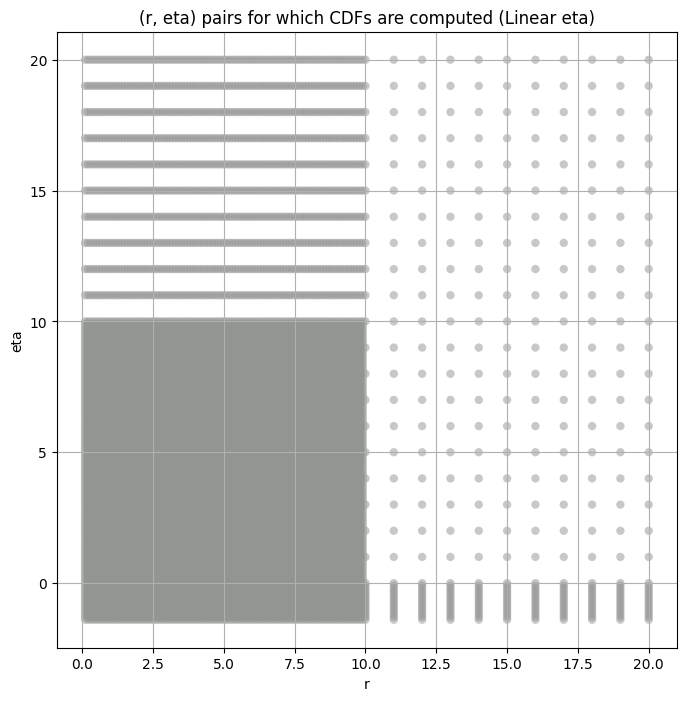

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1702.378200  1542.671600  1868.907700   0.206833   -0.150905   
3       382.921050   361.278260   404.972600   1.138907    0.858473   
4        71.127075    67.076100    75.315895   2.997267    2.384825   
5        12.149980    11.351369    12.987725   4.891086    3.954598   
6         2.038422     1.873556     2.217448   8.822575    6.483714   
7         0.359283     0.323299     0.400608  15.177502   10.213203   
8         0.081781     0.071200     0.096347  31.832588   15.502575   
9         0.019030     0.015809     0.024285  66.977670   25.172220   

       kurt_upper  total_samples  
layer                             
2        0.623989         1604.0  
3        1.443632         6416.0  
4        3.686529        25664.0  
5        6.146631       102656.0  
6       14.781054       410624.0  
7       30.664791      1642496.0  
8      102.338135      6569984.0  
9      248.768720     26279936.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1702.378200    1702.378174     1390.107910     1209.529297   
3       382.921050     382.921051      348.875275      326.534912   
4        71.127075      71.127075       67.548370       65.357620   
5        12.149980      12.149980       11.887744       11.701015   
6         2.038422       2.038422        1.970275        1.928789   
7         0.359283       0.359283        0.342043        0.332173   
8         0.081781       0.081781        0.075820        0.072880   
9         0.019030       0.019030        0.016999        0.016071   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         1066.187500       943.555542       745.244202       592.336853   
3          308.350067       292.179169       265.518036       243.580658   
4           63.566494        62.007393        59.267231        56.884846   
5           11.540997        11.398730        11.151389        10.932463   
6            1.894059         1.863413         1.809665         1.762963   
7            0.324127         0.317114         0.305040         0.294720   
8            0.070519         0.068505         0.065100         0.062242   
9            0.015347         0.014739         0.013739         0.012924   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           468.098785       364.754547       278.932037       106.666893  
3           224.344086       207.349548       192.355194       155.906555  
4            54.773464        52.861774        51.109268        46.580902  
5            10.732754        10.546360        10.371789         9.904933  
6             1.721091         1.682794         1.647383         1.553387  
7             0.285583         0.277349         0.269833         0.250378  
8             0.059755         0.057545         0.055552         0.050499  
9             0.012232         0.011629         0.011095         0.009785

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.025243770456594927 1702.3782


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.0350917613895807 1390.1079


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.05074050950138853 1209.5293


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.06501158296922982 1066.1875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.07856269275391925 943.55554


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.10566955259953337 745.2442


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.13251501085346462 592.33685


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.1586911477720686 468.0988


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.18560929287453332 364.75455


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.2120264925197346 278.93204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.2921923217385225 106.66689
Number of samples: 1604, Without approximation : 1604.0


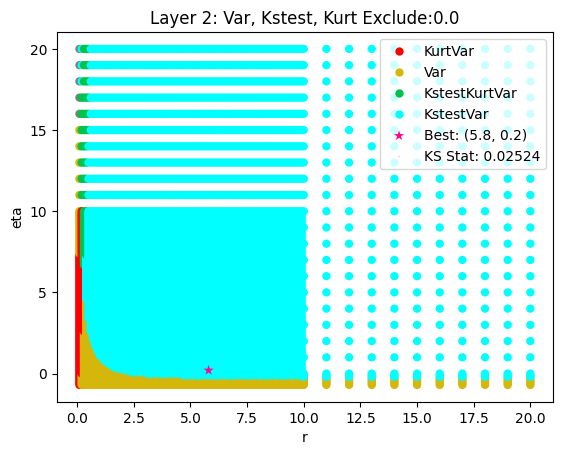

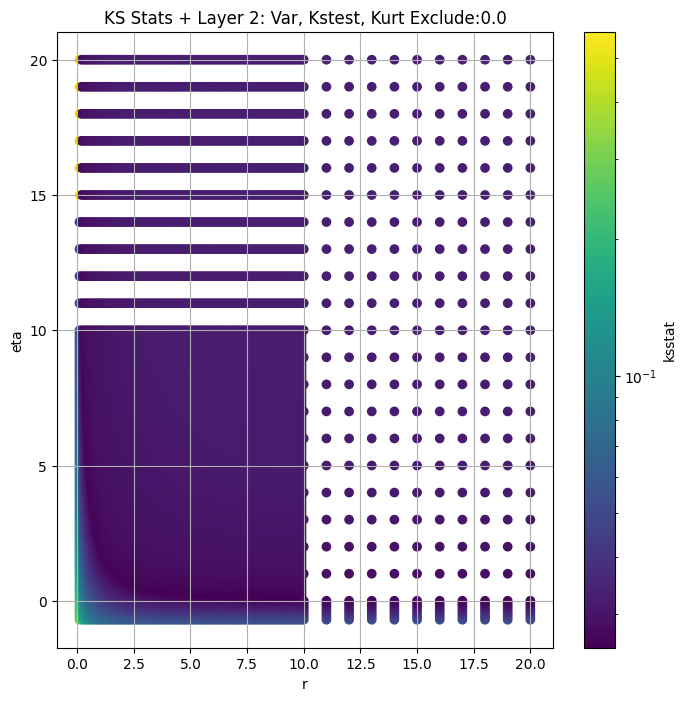

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.010123409286671048 382.92105


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.010715313951854433 348.87527


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.015140847677502456 326.5349


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.019723480203787558 308.35007


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.024041346842283554 292.17917


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.03172080528857457 265.51804


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.03913179436442871 243.58066


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.0462295385632171 224.34409


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.05309820663002607 207.34955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.06052726292688965 192.3552


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08076138610825542 155.90656
Number of samples: 6416, Without approximation : 6416.0


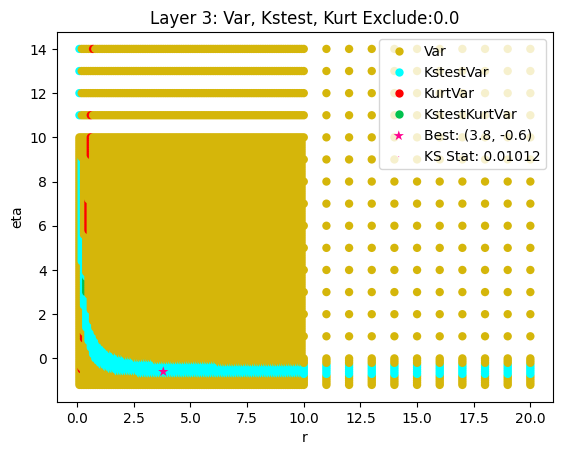

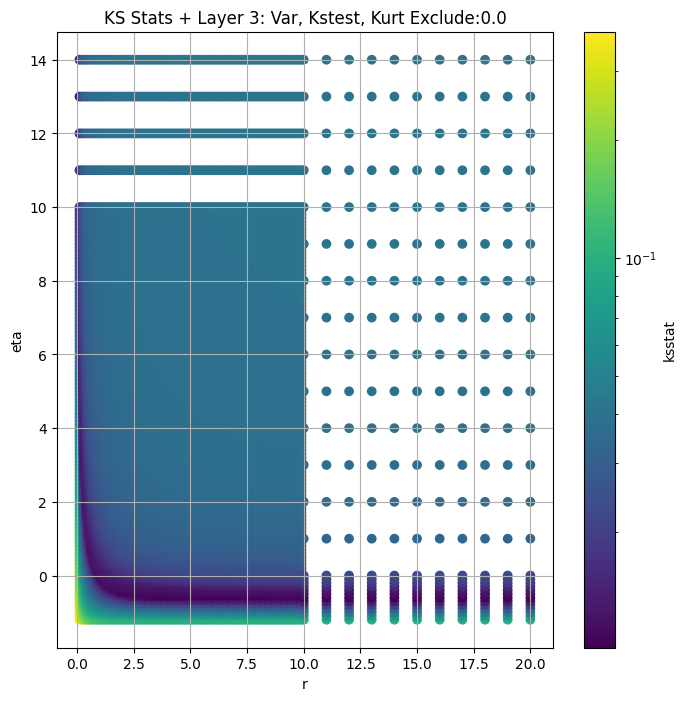

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.004395362125451718 71.127075


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.006967307484438634 67.54837


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.007826391198187732 65.35762


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.008470968785515565 63.566494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.009262668757713421 62.007393


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.011738333284534108 59.26723


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.014831582160348855 56.884846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.016881354867002485 54.773464


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.01923498296581505 52.861774


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.021527650677676702 51.10927


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.028153760383890725 46.580902
Number of samples: 25664, Without approximation : 25664.0


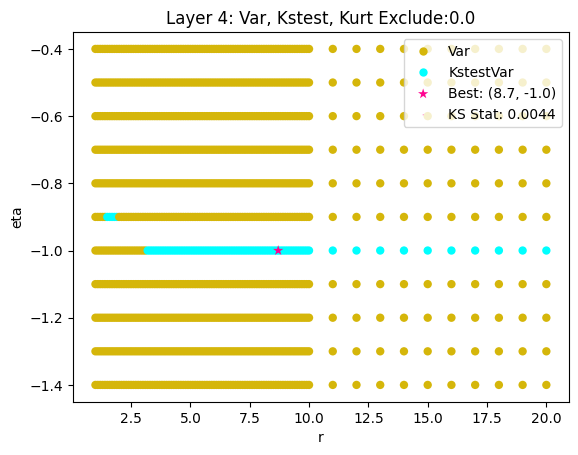

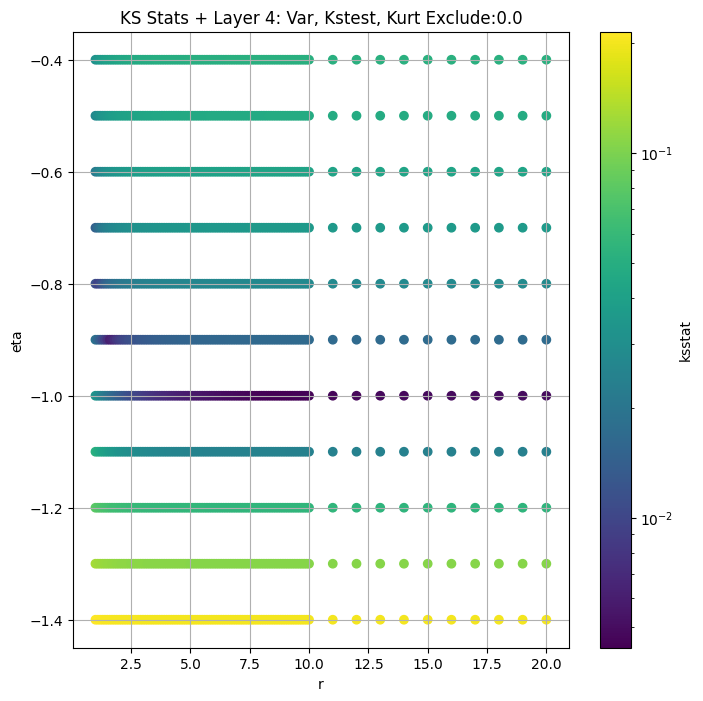

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0070856739166962335 12.14998


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.006922042536622319 11.887744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.006778750594935268 11.7010145


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.006905519215447908 11.540997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.006773135678991404 11.39873


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.006762649803981113 11.151389


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.006780662235042645 10.932463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.007117935326428015 10.732754


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.007655700651447078 10.54636


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.00808410827960198 10.371789


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.009434723788093215 9.904933
Number of samples: 100000, Without approximation : 102656.0


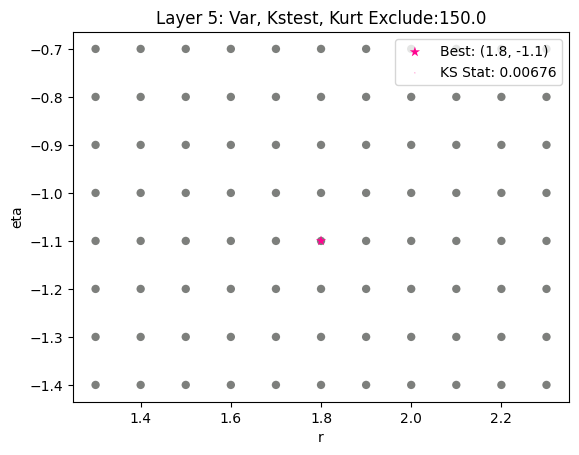

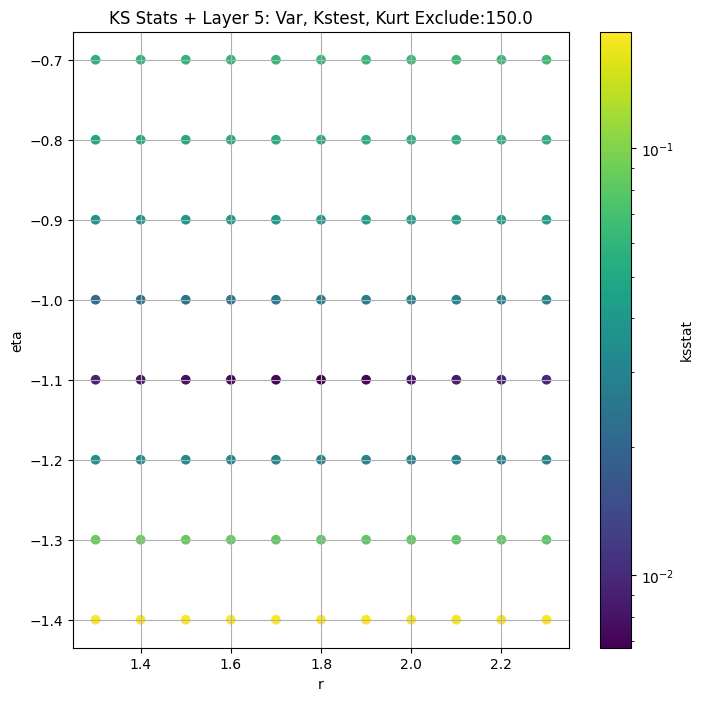

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.014170571614530725 2.0384216


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.01489590205199709 1.9702748


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.01544536626512838 1.9287891


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.015917122591204147 1.894059


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.01577480069374093 1.8634131


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.015485746600697903 1.8096652


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.015225125757554026 1.762963


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.01498409132977302 1.7210908


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.014756744821963819 1.6827937


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.015664779987256572 1.6473835


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.015757889056015384 1.5533872
Number of samples: 100000, Without approximation : 410624.0


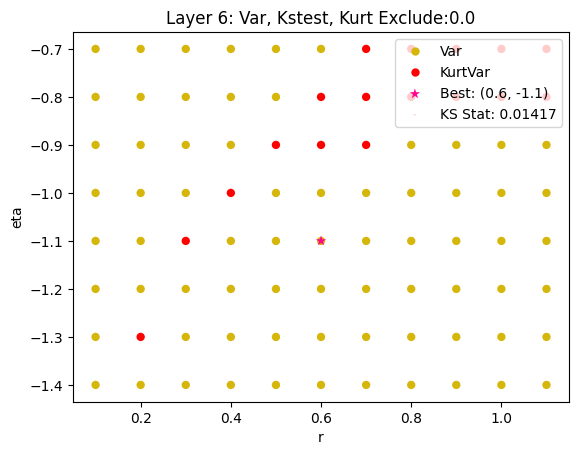

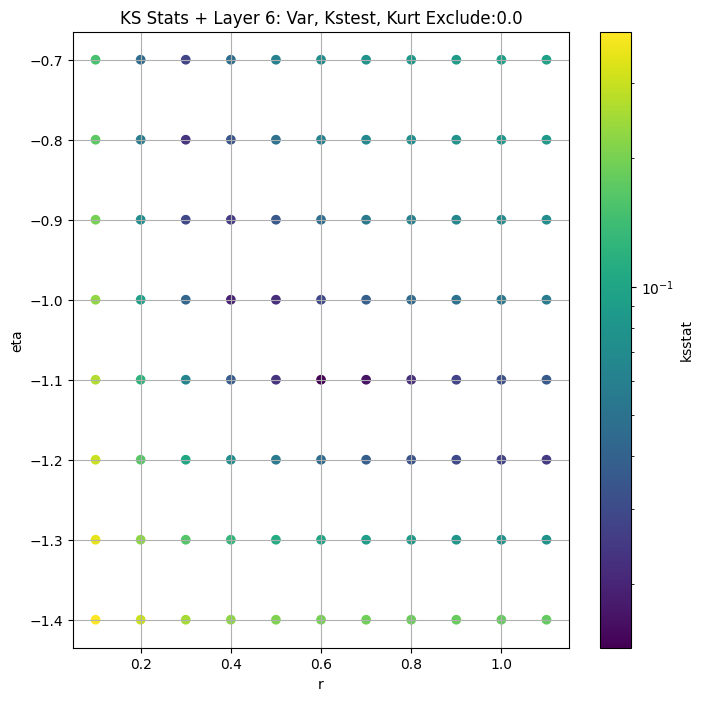

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.017117917817934147 0.35928306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.01717266040580223 0.3420434


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.018460327698643142 0.33217332


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.019543218473968338 0.32412708


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.019819843371873036 0.3171142


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.019020537465770537 0.3050401


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.018305445367200857 0.2947204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.017651185416874937 0.28558263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.017042563617816864 0.2773493


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.018097668570175807 0.2698326


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.01873312236761504 0.25037825
Number of samples: 100000, Without approximation : 1642496.0


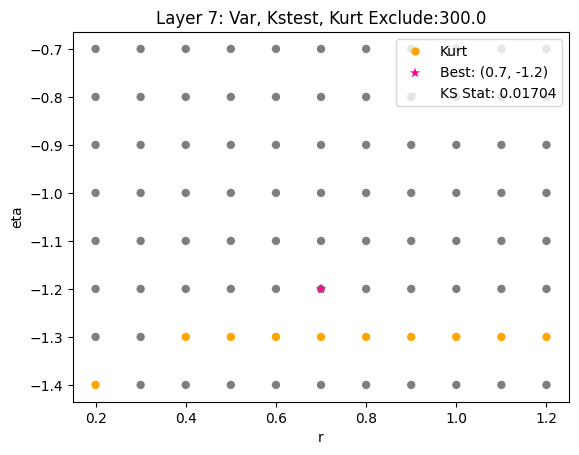

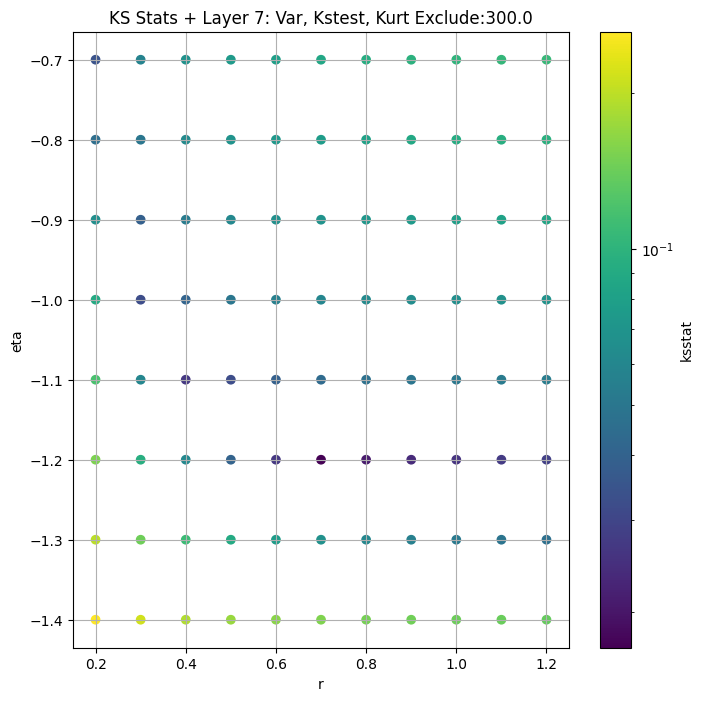

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.008935611255434073 0.08178112


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.006301932465950566 0.07581997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.006215564530591744 0.07288018


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.008117462416137172 0.07051906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.009792176225436738 0.06850522


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.010720061588091578 0.06509983


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.011257599158024156 0.062242474


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.011785226772029311 0.05975505


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.012283184241943856 0.05754548


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.012137660661508565 0.055552002


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.010581322514897733 0.05049929
Number of samples: 100000, Without approximation : 6569984.0


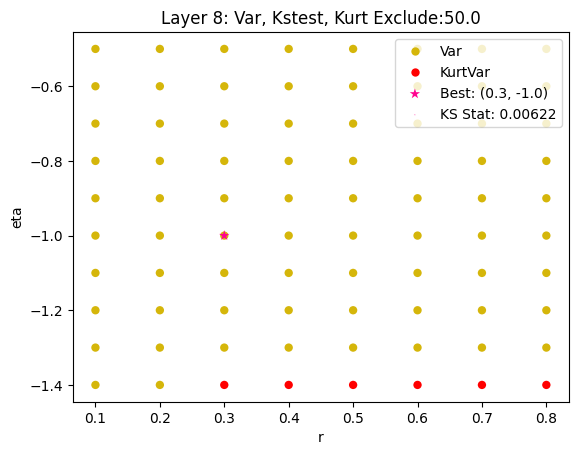

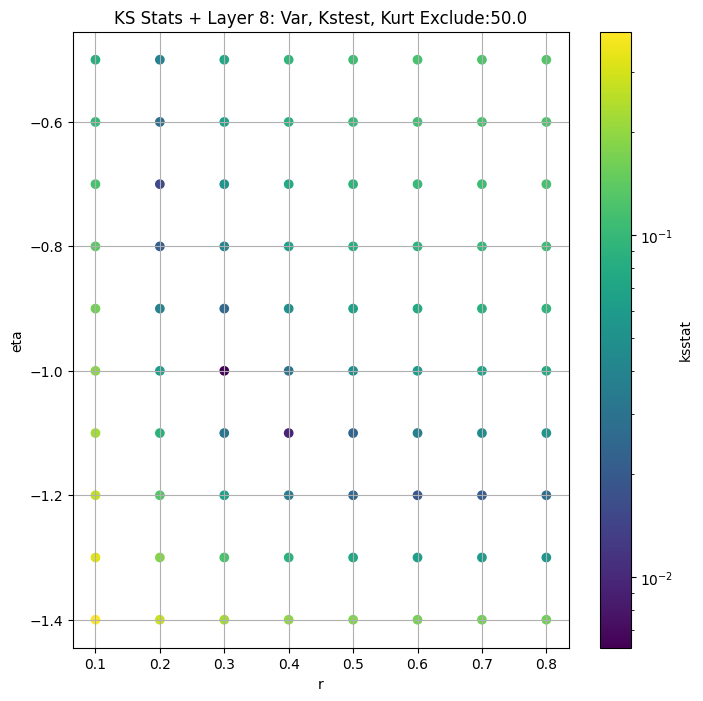

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.02190632514925972 0.019029992


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.017797100294332124 0.016999168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.017190742573176765 0.016070833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.018561038579197442 0.015346842


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.019807611704727557 0.014739131


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.01660792935532429 0.013739211


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.016209214806071515 0.012924178


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.017795799383113153 0.012231954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.017143069523289242 0.011628867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.01848201777840408 0.0110948775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.02027560741313826 0.009784638
Number of samples: 100000, Without approximation : 26279936.0


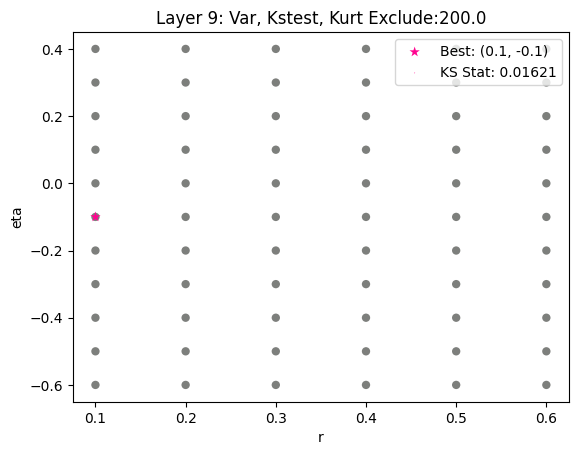

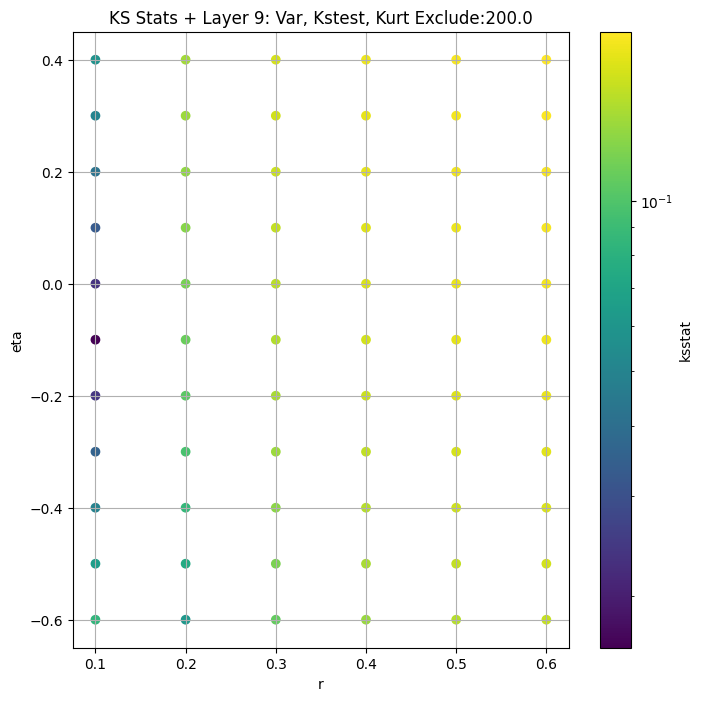

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1702.378200  1542.671600  1868.907700   0.206833   -0.150905   
3       382.921050   361.278260   404.972600   1.138907    0.858473   
4        71.127075    67.076100    75.315895   2.997267    2.384825   
5        12.149980    11.351369    12.987725   4.891086    3.954598   
6         2.038422     1.873556     2.217448   8.822575    6.483714   
7         0.359283     0.323299     0.400608  15.177502   10.213203   
8         0.081781     0.071200     0.096347  31.832588   15.502575   
9         0.019030     0.015809     0.024285  66.977670   25.172220   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.623989         1604.0             0.025244        5.8          0.2   
3        1.443632         6416.0             0.010123        3.8         -0.6   
4        3.686529        25664.0             0.004395        8.7         -1.0   
5        6.146631       102656.0             0.006763        1.8         -1.1   
6       14.781054       410624.0             0.014171        0.6         -1.1   
7       30.664791      1642496.0             0.017043        0.7         -1.2   
8      102.338135      6569984.0             0.006216        0.3         -1.0   
9      248.768720     26279936.0             0.016209        0.1         -0.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.743262e+03                     0.0         1702.378200   
3       8.293569e+02                     0.0          382.921050   
4       2.235116e+02                     0.0           71.127075   
5       3.847752e+01                   150.0           11.151389   
6       2.318303e+00                     0.0            2.038422   
7       6.050039e-01                   300.0            0.277349   
8       2.741343e-03                    50.0            0.072880   
9       3.113069e-15                   200.0            0.012924   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033804  
3                     0.016929  
4                     0.008471  
5                     0.004237  
6                     0.002119  
7                     0.001060  
8                     0.000530  
9                     0.000265

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/117 [00:00<?, ?it/s]

Finding Minimum after computing 117 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.08572443022910015, var: 943.5555419921875


  0%|          | 0/117 [00:00<?, ?it/s]

Finding Minimum after computing 117 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.07179205638199226, var: 1066.1875


  0%|          | 0/117 [00:00<?, ?it/s]

Finding Minimum after computing 117 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.057434070759866285, var: 1209.529296875


  0%|          | 0/117 [00:00<?, ?it/s]

Finding Minimum after computing 117 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.04173205300790961, var: 1390.10791015625


  0%|          | 0/117 [00:00<?, ?it/s]

Finding Minimum after computing 117 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.025243770456594927, var: 1702.378173828125
Number of samples: 1604, Without approximation : 1604.0


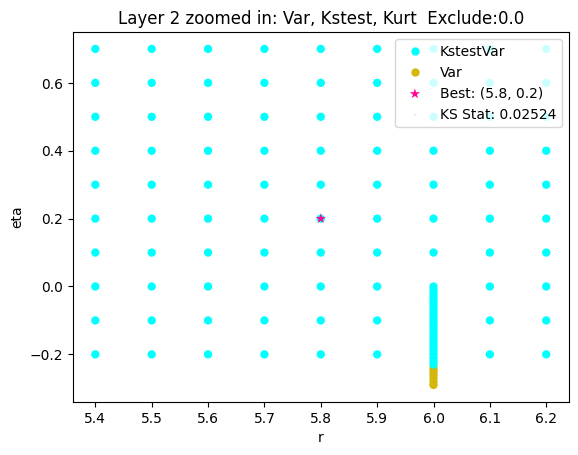

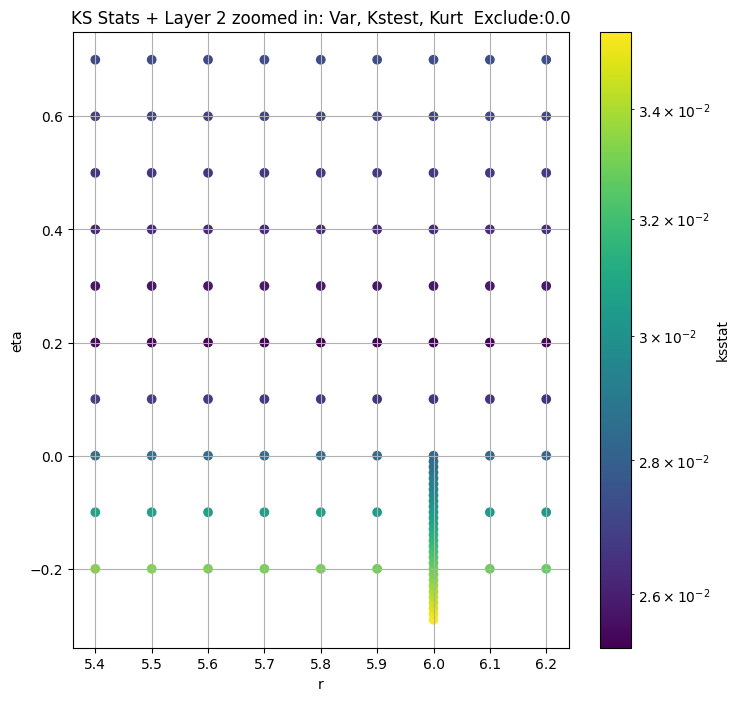

Layer 3


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.024772025816242382, var: 292.1791687011719


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.02047676253041808, var: 308.3500671386719


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.01583911821931061, var: 326.534912109375


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.010954081342789412, var: 348.8752746582031


  0%|          | 0/171 [00:00<?, ?it/s]

Finding Minimum after computing 171 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.010123409286671048, var: 382.9210510253906
Number of samples: 6416, Without approximation : 6416.0


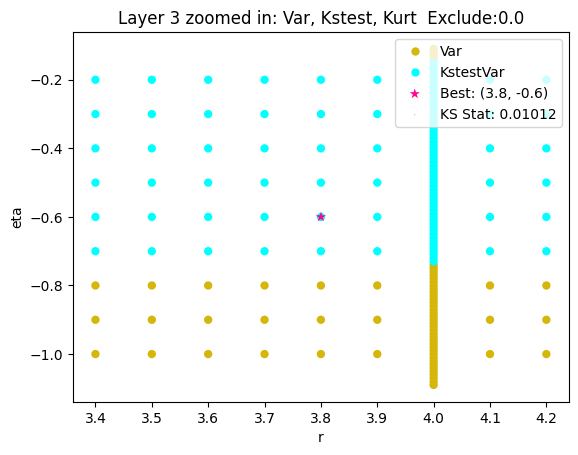

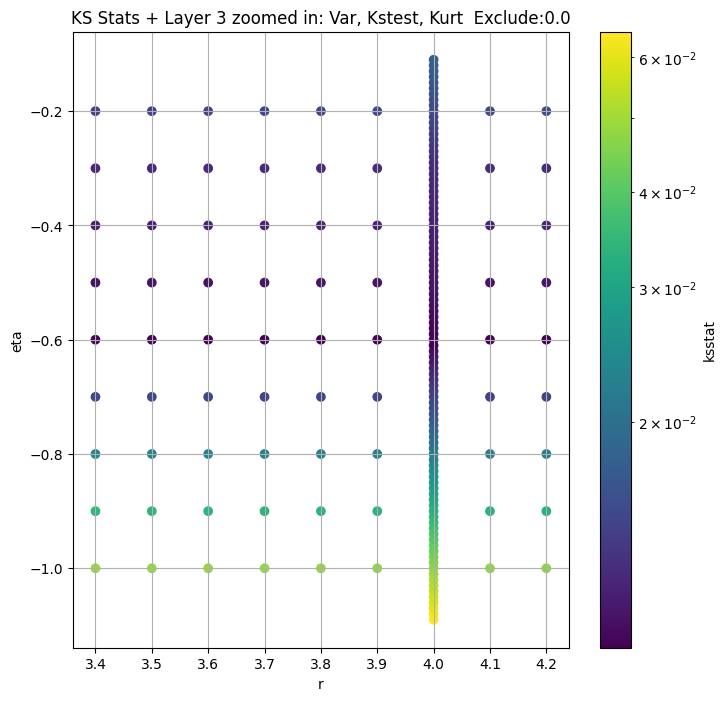

Layer 4


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.00909510065861363, var: 62.00739288330078


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.007553855090491668, var: 63.56649398803711


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.005842568697954298, var: 65.35762023925781


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.004007630220567049, var: 67.54837036132812


  0%|          | 0/167 [00:00<?, ?it/s]

Finding Minimum after computing 167 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.004395362125451718, var: 71.1270751953125
Number of samples: 25664, Without approximation : 25664.0


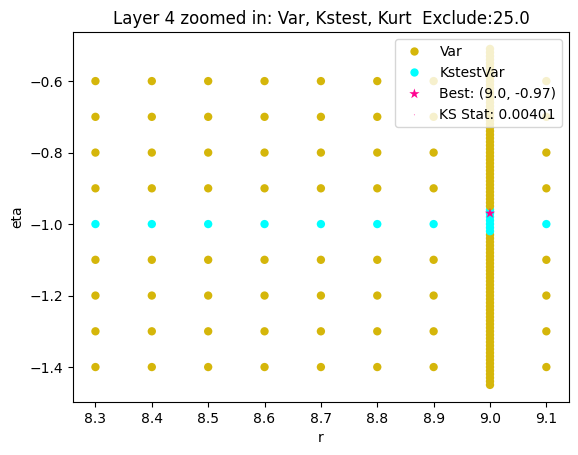

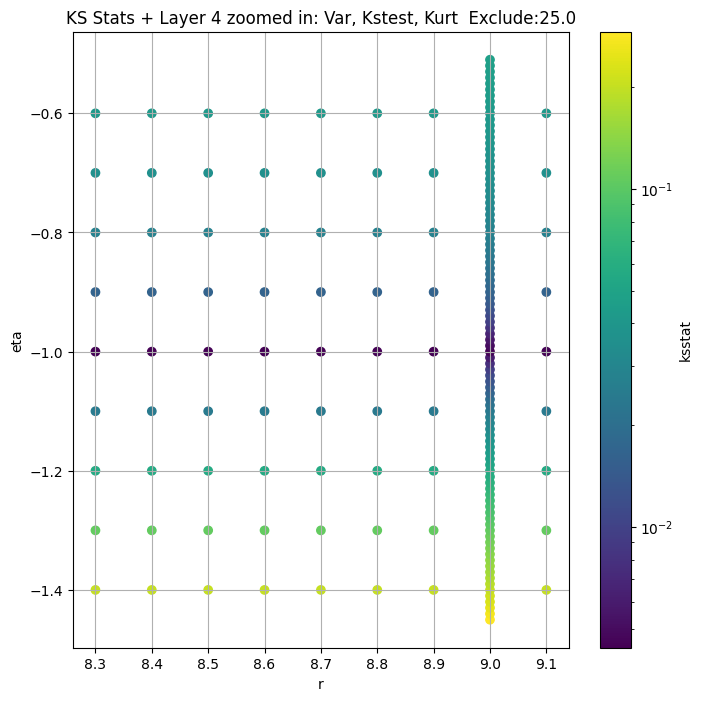

Layer 5


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 150.0 + 100 = 250, ksstat: 0.007117935326428015, var: 10.73275375366211


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 150.0 + 75 = 225, ksstat: 0.006982300777564399, var: 10.830623626708984


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 150.0 + 50 = 200, ksstat: 0.006631075978204892, var: 10.932462692260742


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 150.0 + 25 = 175, ksstat: 0.006654924053142164, var: 11.03909683227539


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 150.0 + 0 = 150, ksstat: 0.006664517758857458, var: 11.151389122009277


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 150.0 + -25 = 125, ksstat: 0.006462052864726196, var: 11.270313262939453


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 150.0 + -50 = 100, ksstat: 0.006420393598332241, var: 11.398730278015137


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 150.0 + -75 = 75, ksstat: 0.006317831005043573, var: 11.540996551513672


  0%|          | 0/1123 [00:00<?, ?it/s]

Finding Minimum after computing 1123 CDFs
layer 5, 150.0 + -100 = 50, ksstat: 0.0061919419593550185, var: 11.701014518737793
Number of samples: 100000, Without approximation : 102656.0


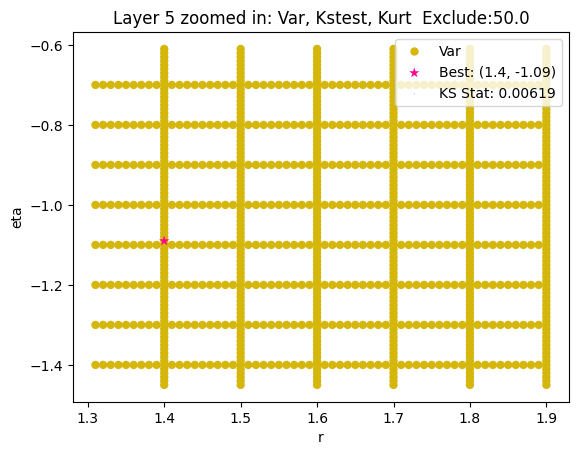

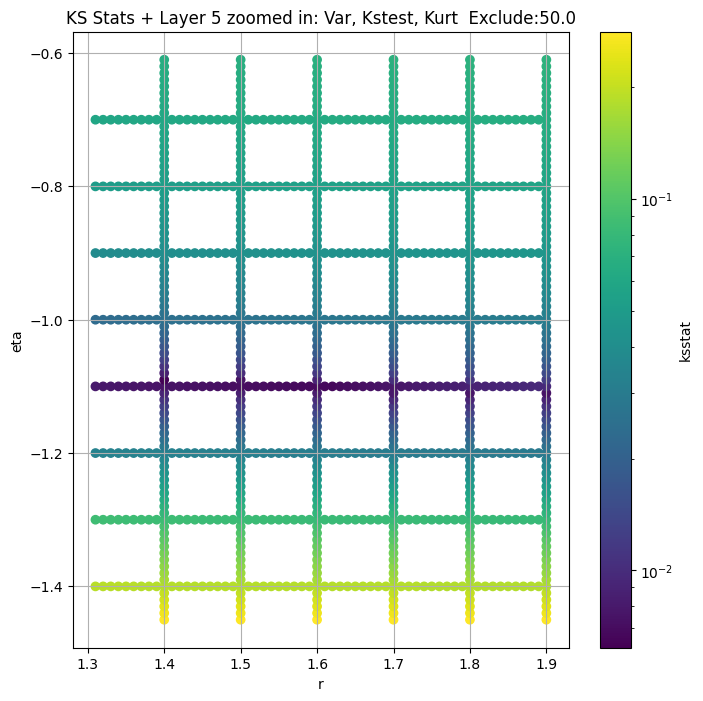

Layer 6


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.01312534438450741, var: 1.8634130954742432


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.013127540808675564, var: 1.8940589427947998


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.013550082649534001, var: 1.9287891387939453


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.013763255757954285, var: 1.970274806022644


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.013702816853720434, var: 2.038421630859375
Number of samples: 100000, Without approximation : 410624.0


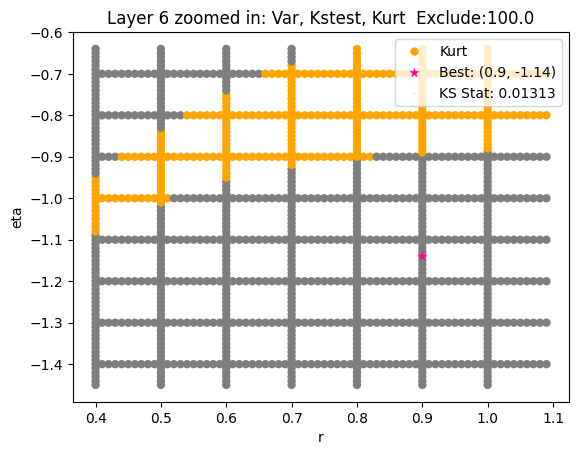

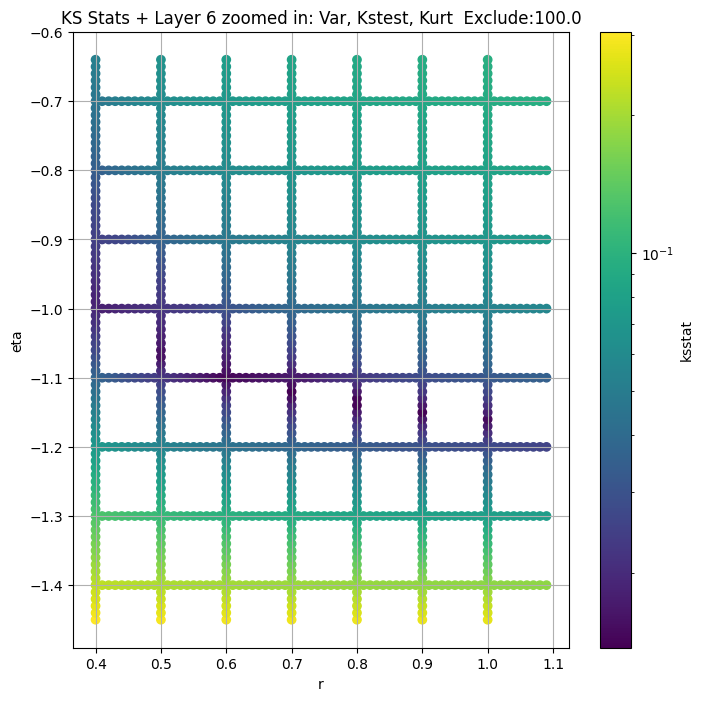

Layer 7


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 300.0 + 100 = 400, ksstat: 0.015152072565543573, var: 0.26290130615234375


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 300.0 + 75 = 375, ksstat: 0.015146278802041557, var: 0.26630109548568726


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 300.0 + 50 = 350, ksstat: 0.014596395104302329, var: 0.2698326110839844


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 300.0 + 25 = 325, ksstat: 0.014257003880388586, var: 0.27350932359695435


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 300.0 + 0 = 300, ksstat: 0.01454090622701748, var: 0.2773492932319641


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 300.0 + -25 = 275, ksstat: 0.014441800196622556, var: 0.281366229057312


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 300.0 + -50 = 250, ksstat: 0.013840731059046152, var: 0.28558263182640076


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 300.0 + -75 = 225, ksstat: 0.013219380850782336, var: 0.2900194525718689


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 300.0 + -100 = 200, ksstat: 0.013253377847735393, var: 0.2947204113006592
Number of samples: 100000, Without approximation : 1642496.0


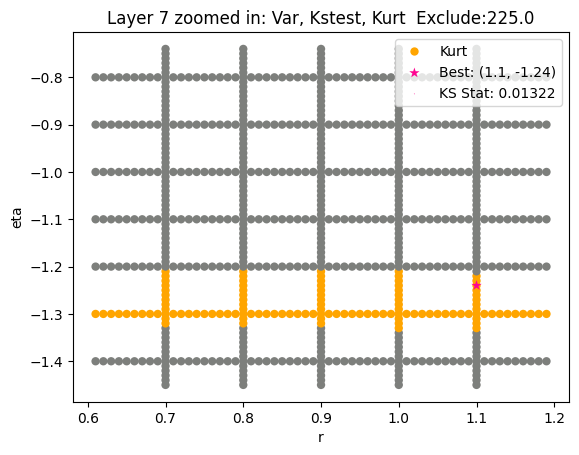

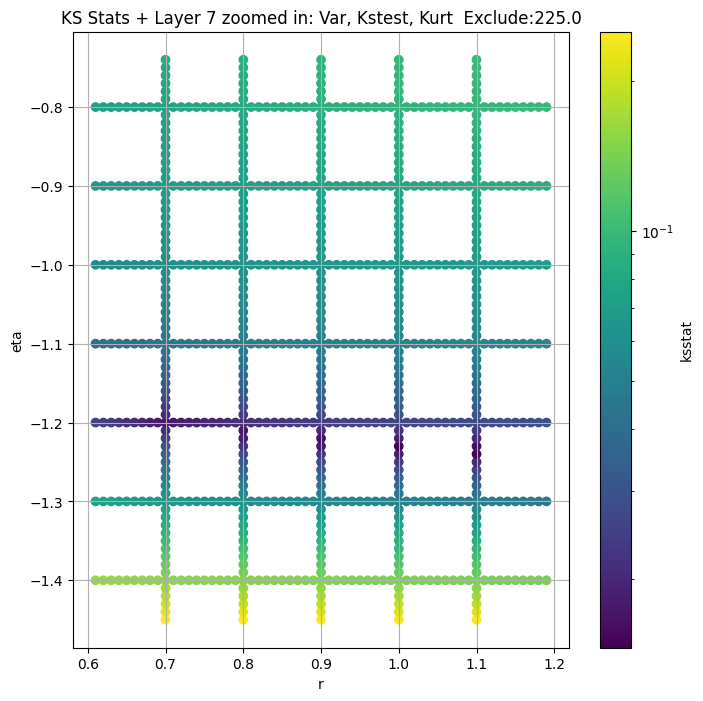

Layer 8


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + 100 = 150, ksstat: 0.007767773474328665, var: 0.06509982794523239


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + 75 = 125, ksstat: 0.00767450077275611, var: 0.06671833246946335


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + 50 = 100, ksstat: 0.007171588280325714, var: 0.06850522011518478


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + 25 = 75, ksstat: 0.0067927480143166186, var: 0.07051905989646912


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + 0 = 50, ksstat: 0.006215564530591744, var: 0.07288017868995667


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + -25 = 25, ksstat: 0.006301932465950566, var: 0.0758199691772461


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 8, 50.0 + -50 = 0, ksstat: 0.006149261163269193, var: 0.08178111910820007
Number of samples: 100000, Without approximation : 6569984.0


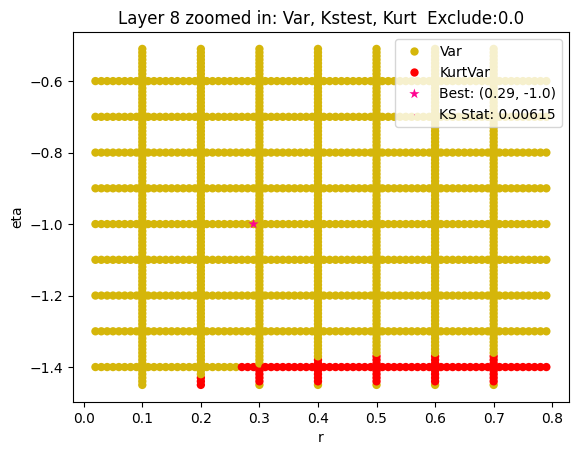

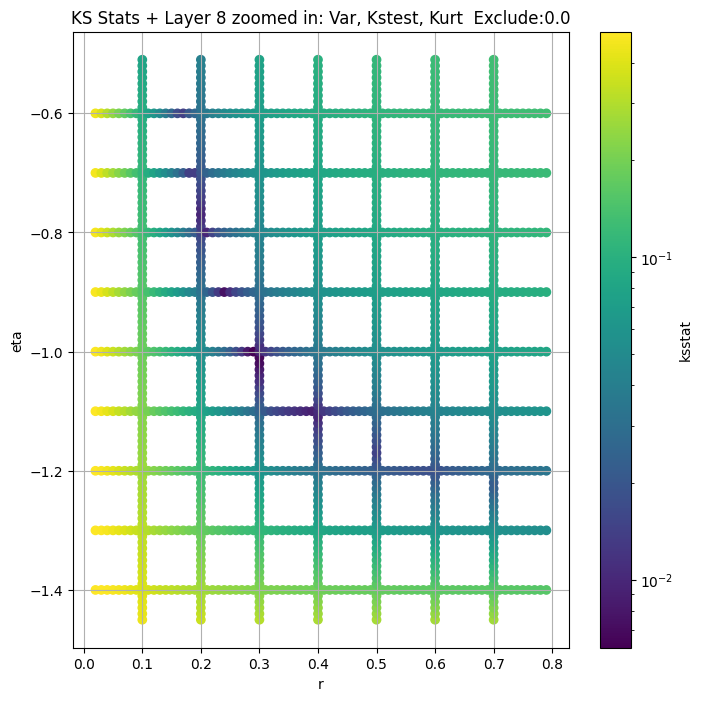

Layer 9


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 200.0 + 100 = 300, ksstat: 0.016293593994390787, var: 0.011628867127001286


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 200.0 + 75 = 275, ksstat: 0.01666035119949405, var: 0.01192067563533783


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 200.0 + 50 = 250, ksstat: 0.016186971848323614, var: 0.012231954373419285


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 200.0 + 25 = 225, ksstat: 0.016147015624256515, var: 0.012565200217068195


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 200.0 + 0 = 200, ksstat: 0.01577287488963105, var: 0.012924177572131157


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 200.0 + -25 = 175, ksstat: 0.015369471375434977, var: 0.013313261792063713


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 200.0 + -50 = 150, ksstat: 0.014929955277082518, var: 0.013739210553467274


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 200.0 + -75 = 125, ksstat: 0.015313534972785092, var: 0.014210376888513565


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 200.0 + -100 = 100, ksstat: 0.015371885149814135, var: 0.01473913062363863
Number of samples: 100000, Without approximation : 26279936.0


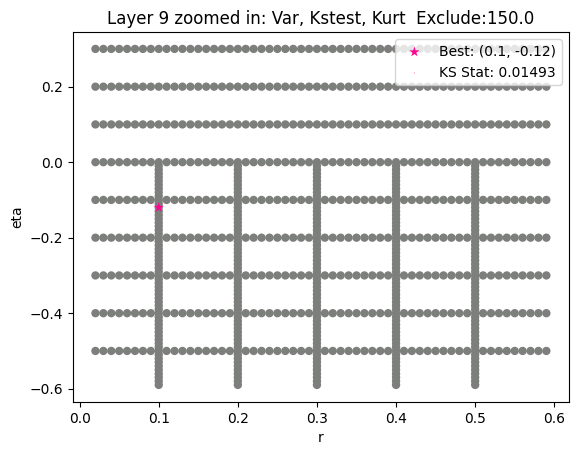

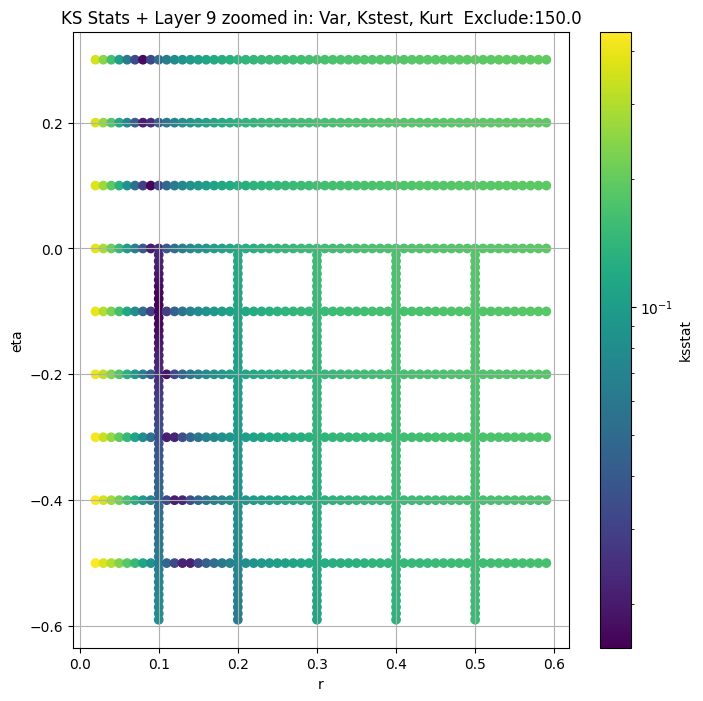

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1702.378200  1542.671600  1868.907700   0.206833   -0.150905   
3       382.921050   361.278260   404.972600   1.138907    0.858473   
4        71.127075    67.076100    75.315895   2.997267    2.384825   
5        12.149980    11.351369    12.987725   4.891086    3.954598   
6         2.038422     1.873556     2.217448   8.822575    6.483714   
7         0.359283     0.323299     0.400608  15.177502   10.213203   
8         0.081781     0.071200     0.096347  31.832588   15.502575   
9         0.019030     0.015809     0.024285  66.977670   25.172220   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.623989         1604.0             0.025244        5.8          0.2   
3        1.443632         6416.0             0.010123        3.8         -0.6   
4        3.686529        25664.0             0.004395        8.7         -1.0   
5        6.146631       102656.0             0.006763        1.8         -1.1   
6       14.781054       410624.0             0.014171        0.6         -1.1   
7       30.664791      1642496.0             0.017043        0.7         -1.2   
8      102.338135      6569984.0             0.006216        0.3         -1.0   
9      248.768720     26279936.0             0.016209        0.1         -0.1   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       2.743262e+03                     0.0         1702.378200   
3       8.293569e+02                     0.0          382.921050   
4       2.235116e+02                     0.0           67.548370   
5       3.847752e+01                   150.0           11.701015   
6       2.318303e+00                     0.0            1.863413   
7       6.050039e-01                   300.0            0.290019   
8       2.741343e-03                    50.0            0.081781   
9       3.113069e-15                   200.0            0.013739   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033804          0.025244    5.80      0.20   
3                     0.016929          0.010123    3.80     -0.60   
4                     0.008471          0.004008    9.00     -0.97   
5                     0.004237          0.006192    1.40     -1.09   
6                     0.002119          0.013125    0.90     -1.14   
7                     0.001060          0.013219    1.10     -1.24   
8                     0.000530          0.006149    0.29     -1.00   
9                     0.000265          0.014930    0.10     -0.12   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      2.743262e+03                  0.0         3043  
3      8.293569e+02                  0.0        18270  
4      2.039547e+02                 25.0       109623  
5      3.604938e+01                 50.0        48721  
6      4.661825e+00                100.0        10827  
7      1.193870e+00                225.0        10827  
8      2.392944e-03                  0.0        51328  
9      3.699618e-15                150.0         8119

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

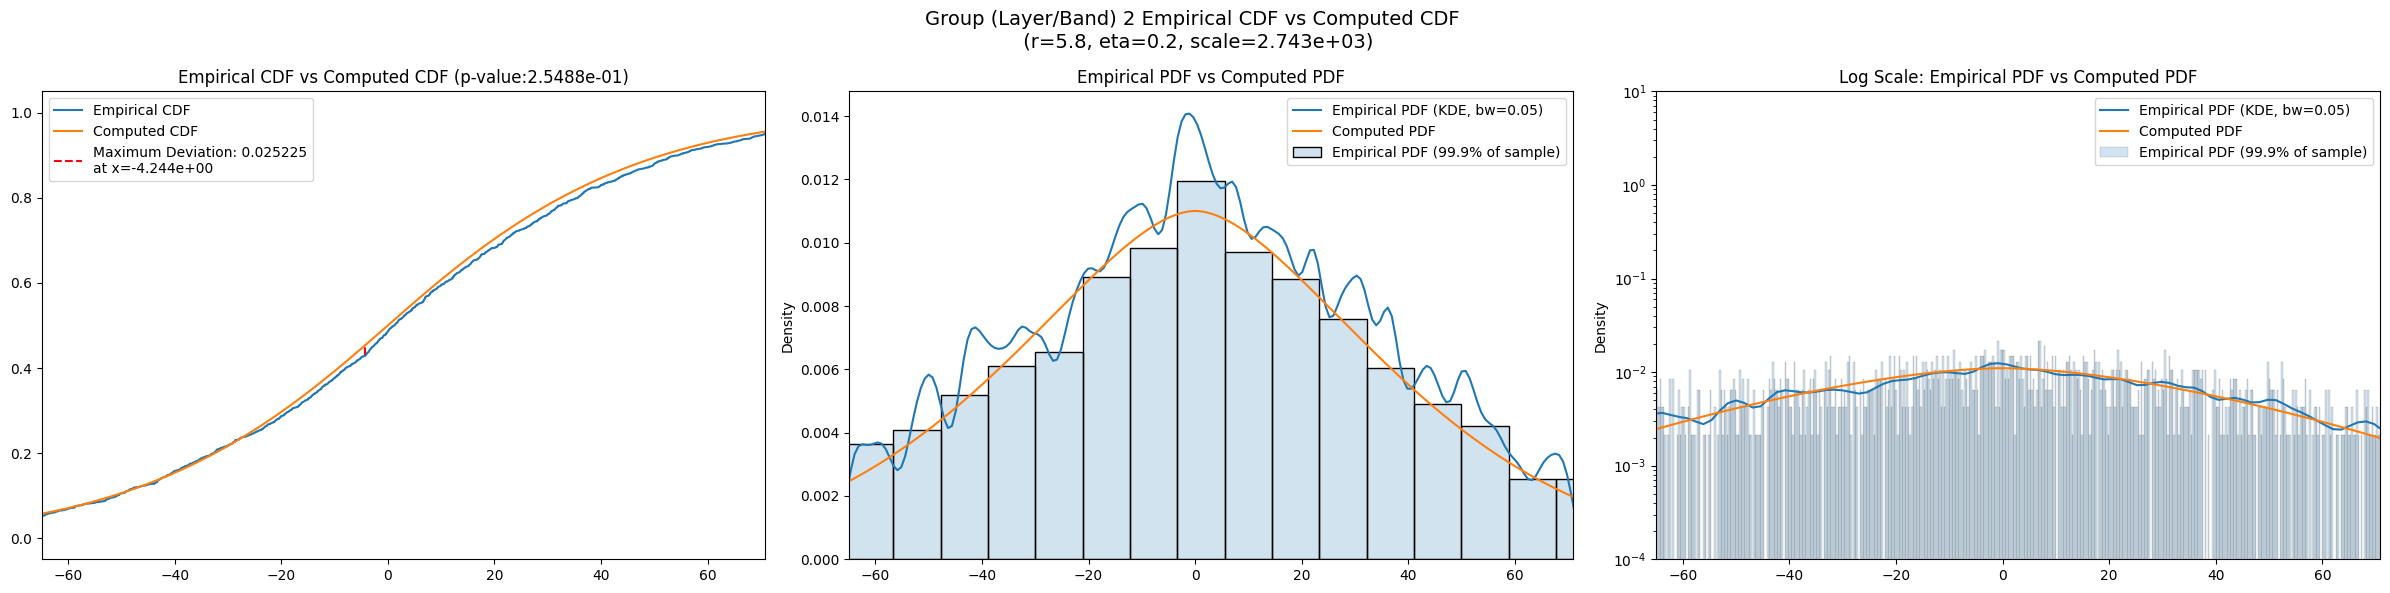

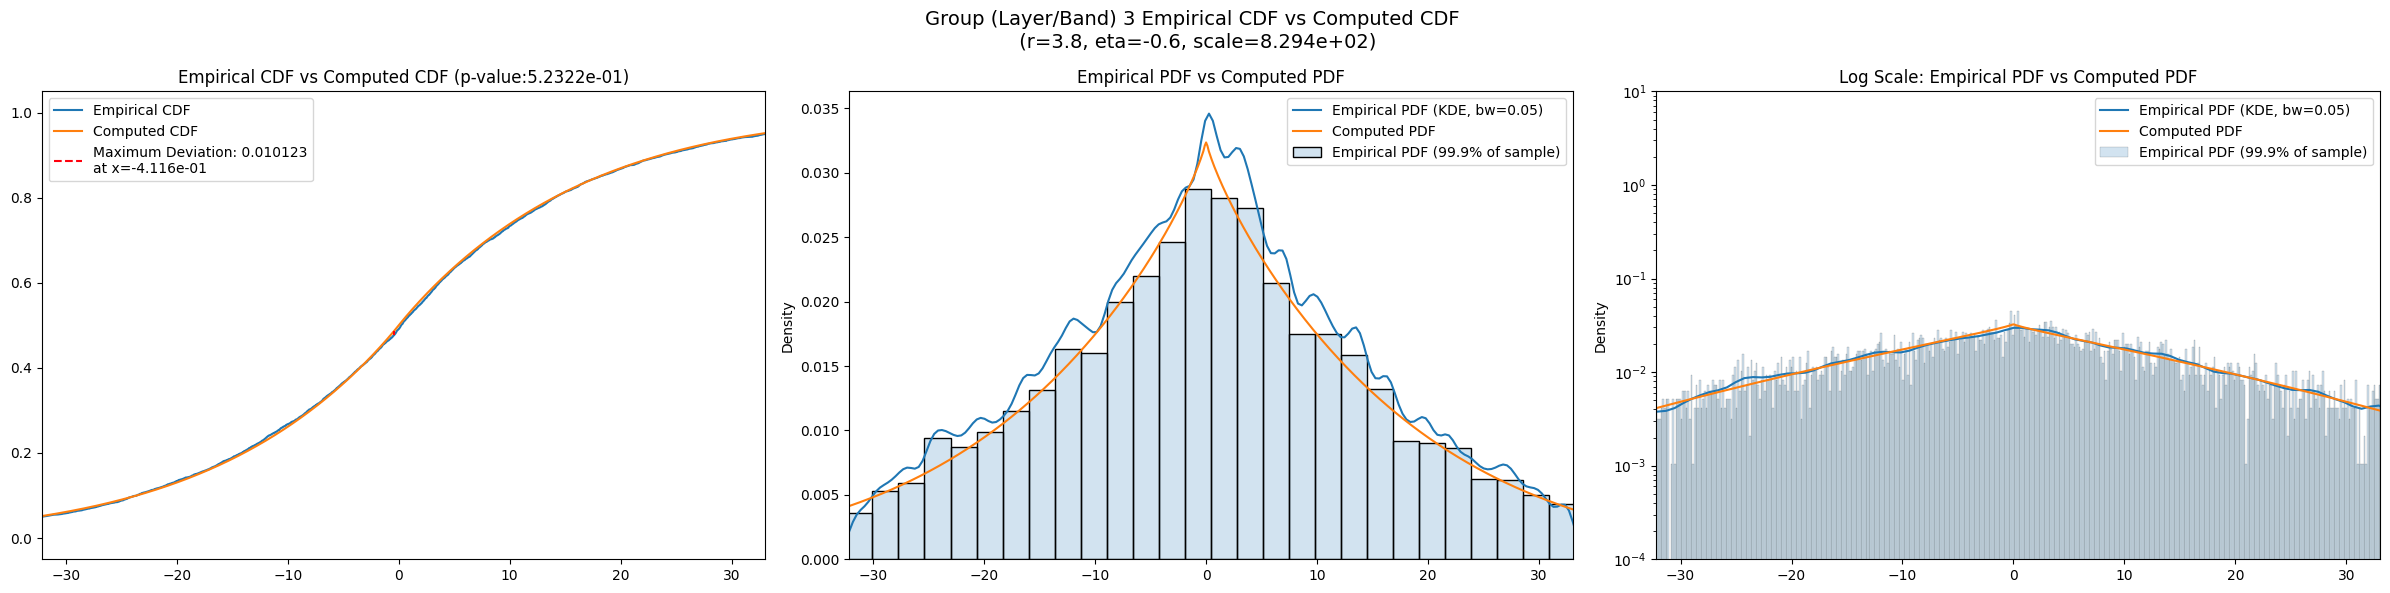

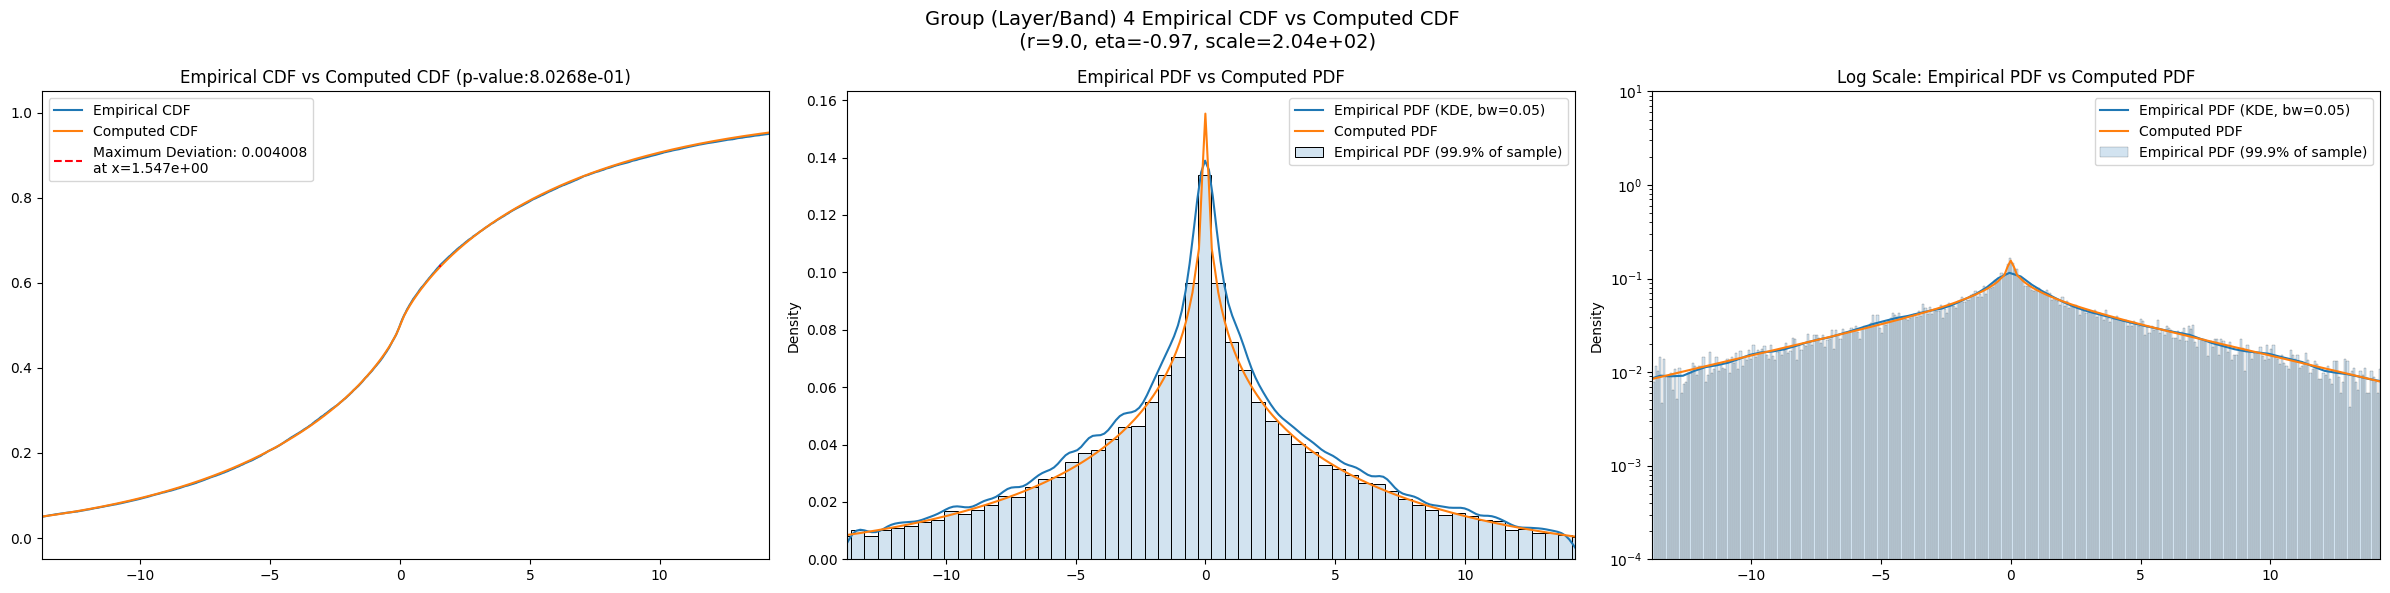

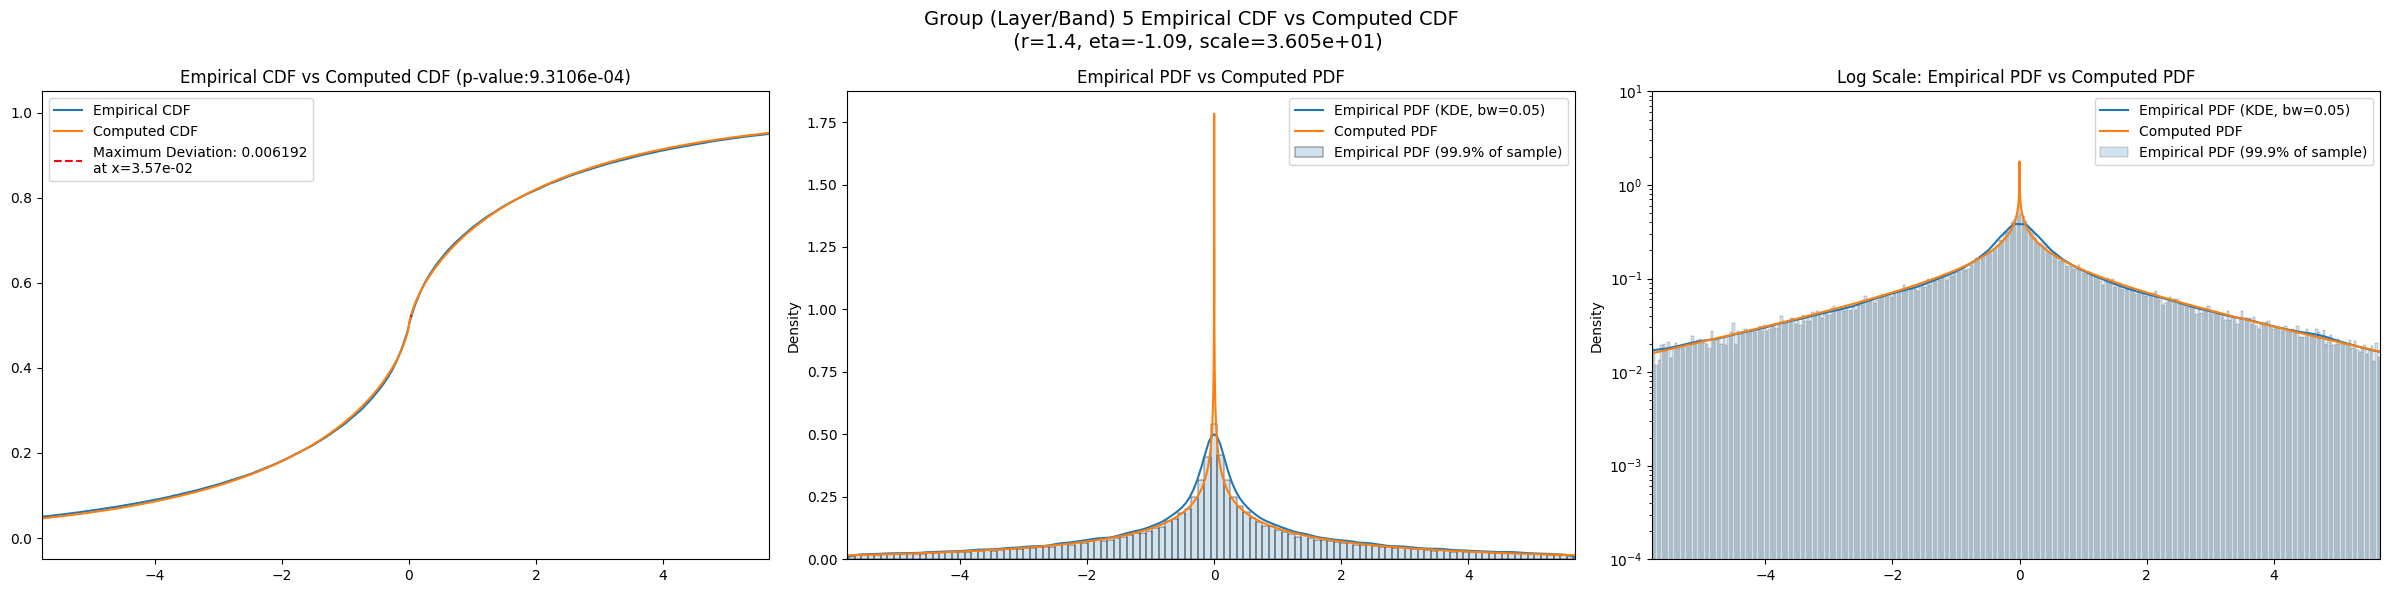

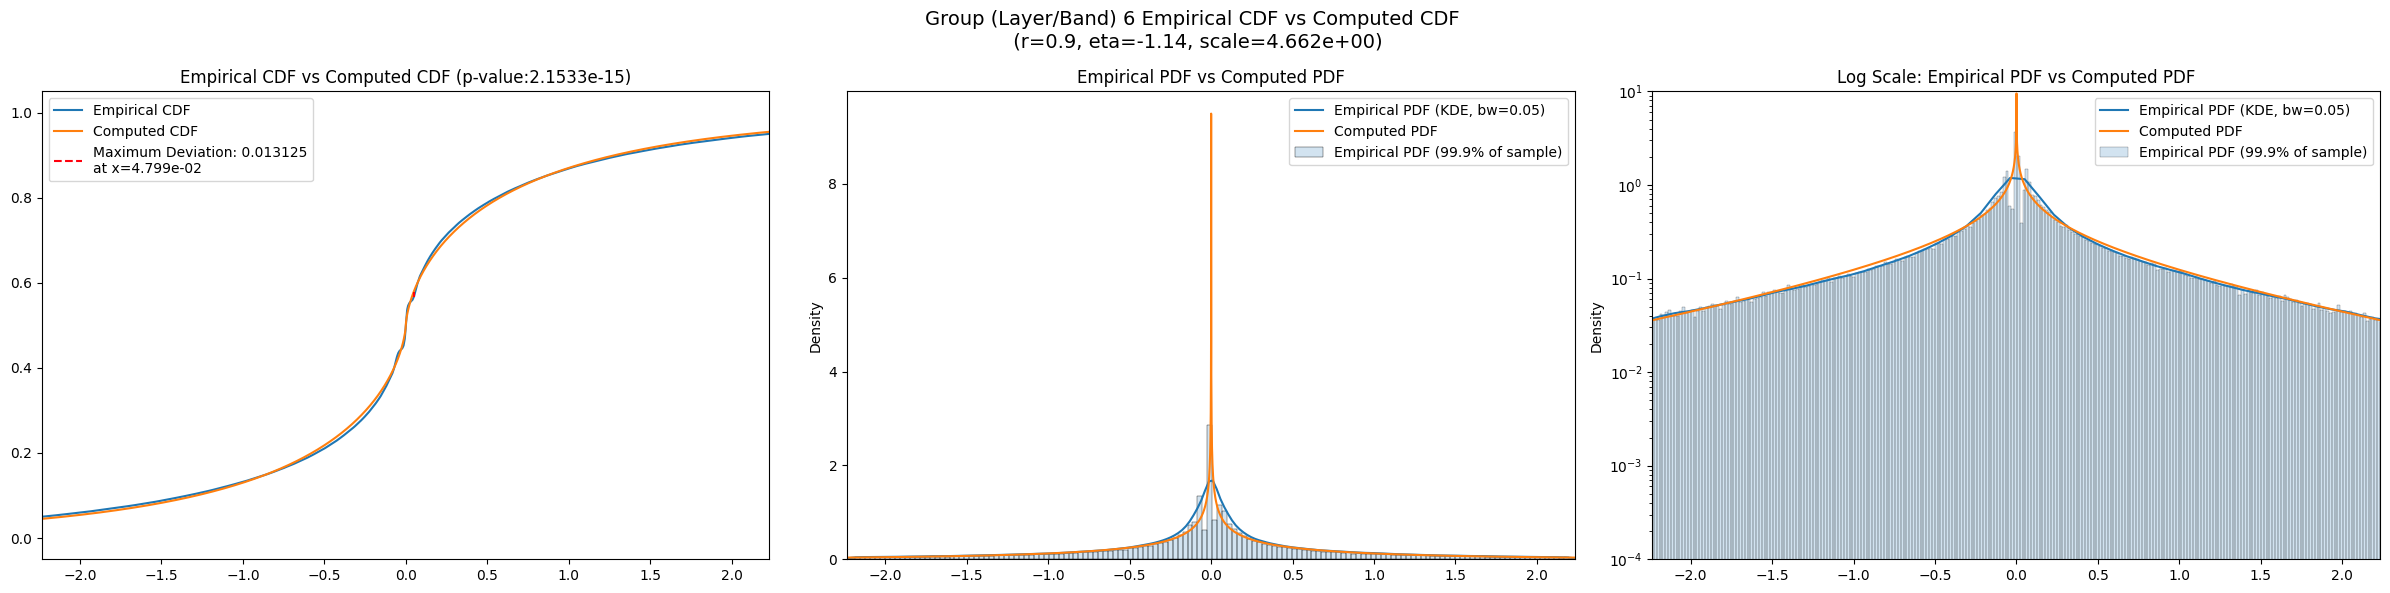

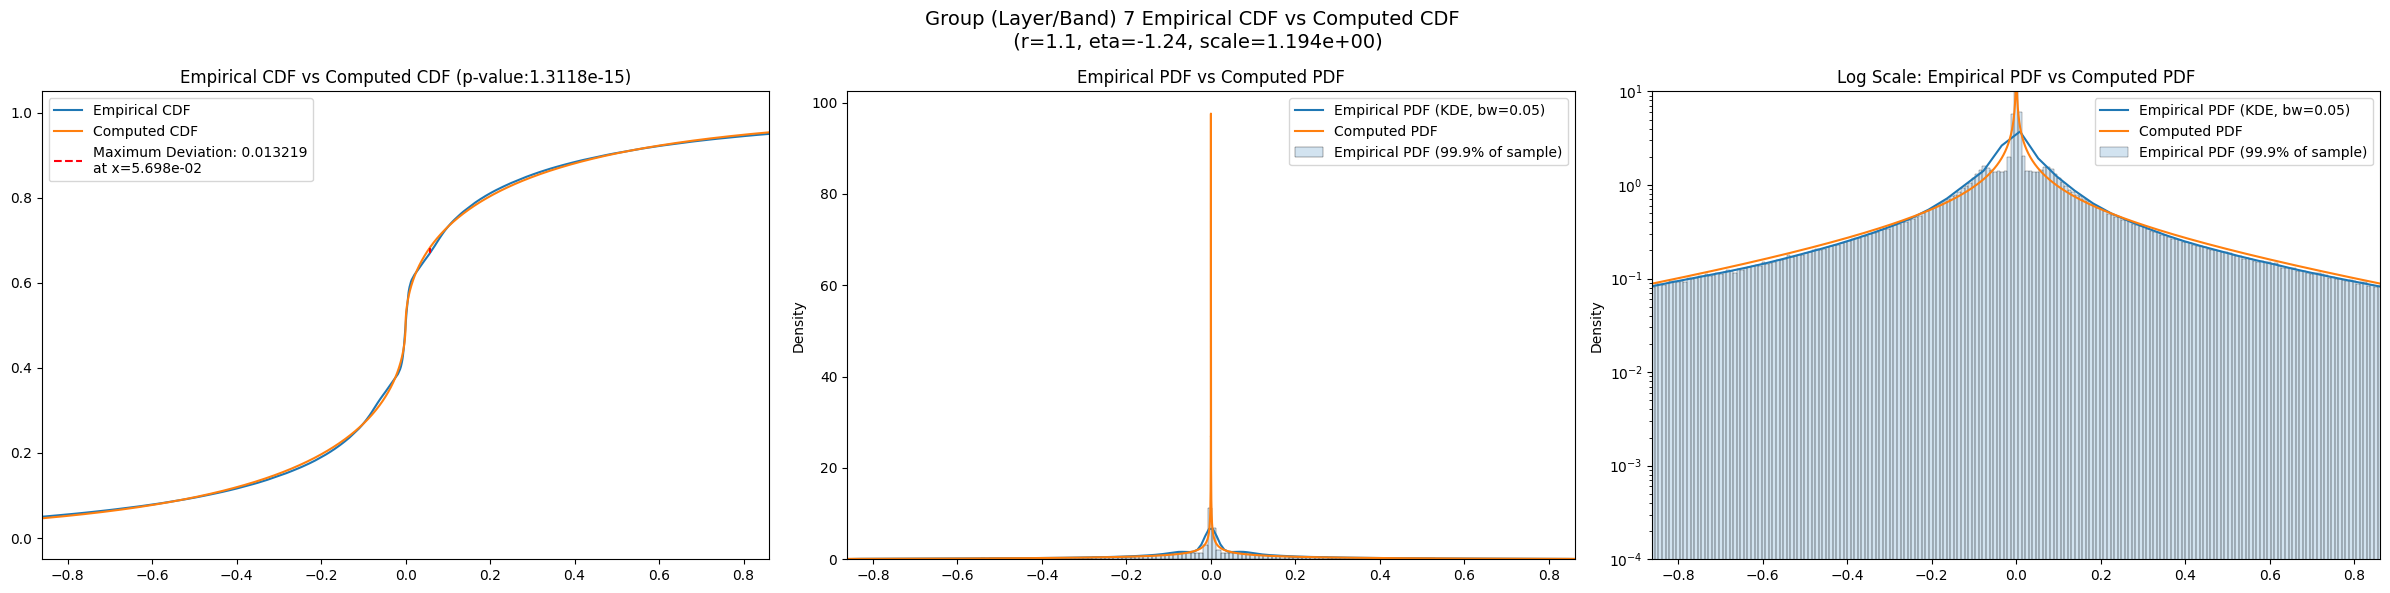

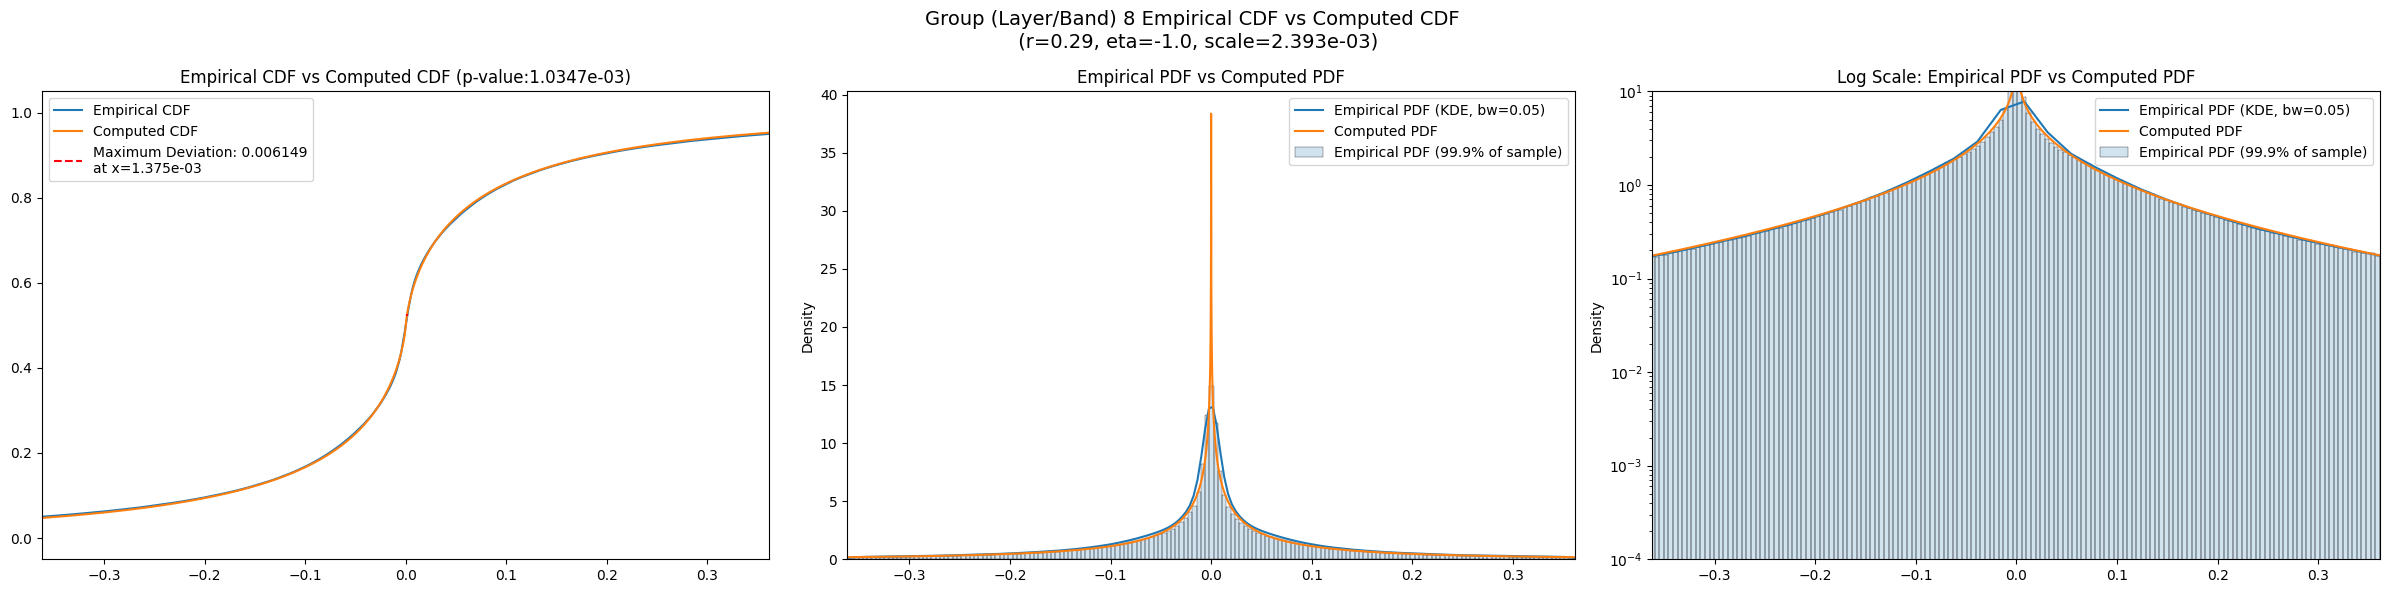

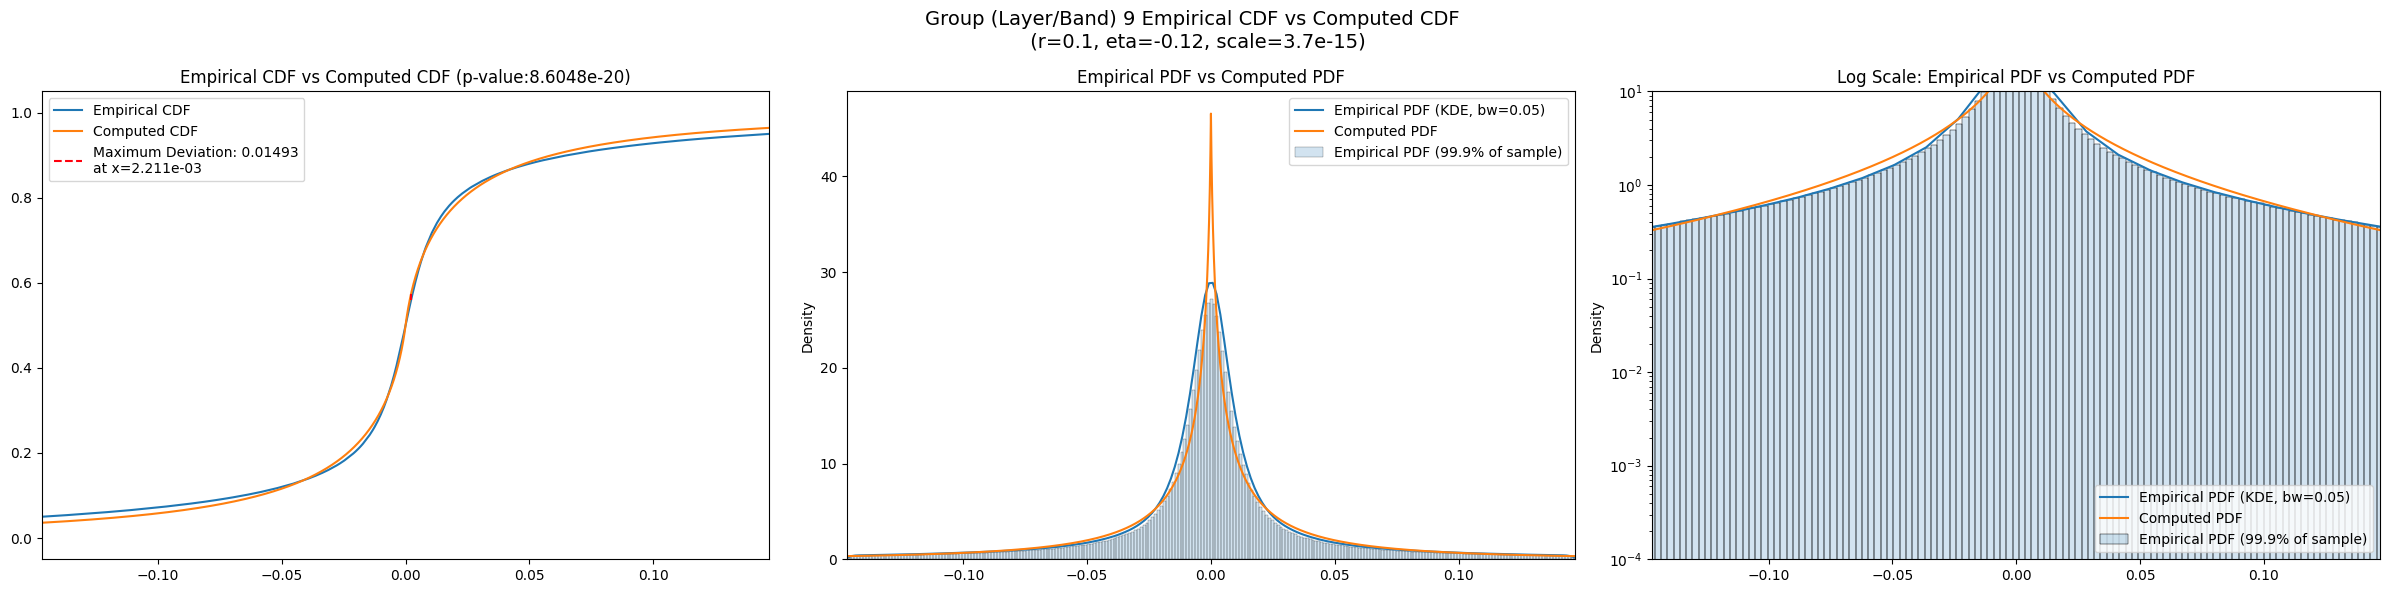

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1702.378200  1542.671600  1868.907700   0.206833   -0.150905   
3       382.921050   361.278260   404.972600   1.138907    0.858473   
4        71.127075    67.076100    75.315895   2.997267    2.384825   
5        12.149980    11.351369    12.987725   4.891086    3.954598   
6         2.038422     1.873556     2.217448   8.822575    6.483714   
7         0.359283     0.323299     0.400608  15.177502   10.213203   
8         0.081781     0.071200     0.096347  31.832588   15.502575   
9         0.019030     0.015809     0.024285  66.977670   25.172220   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        0.623989         1604.0             0.025244        5.8          0.2   
3        1.443632         6416.0             0.010123        3.8         -0.6   
4        3.686529        25664.0             0.004395        8.7         -1.0   
5        6.146631       102656.0             0.006763        1.8         -1.1   
6       14.781054       410624.0             0.014171        0.6         -1.1   
7       30.664791      1642496.0             0.017043        0.7         -1.2   
8      102.338135      6569984.0             0.006216        0.3         -1.0   
9      248.768720     26279936.0             0.016209        0.1         -0.1   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       38.508900              0.027814          1.640290e-01   
3      ...       17.441000              0.023651          1.501420e-03   
4      ...        6.247750              0.043899          2.046930e-43   
5      ...        2.088260              0.062537          0.000000e+00   
6      ...        0.677307              0.076378          0.000000e+00   
7      ...        0.225574              0.082559          0.000000e+00   
8      ...        0.093843              0.079298          0.000000e+00   
9      ...        0.031065              0.083603          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          35.693300             0.034969         3.863530e-02  29.499300   
3          15.238300             0.011604         3.506200e-01  12.443500   
4           5.424350             0.018552         4.197750e-08   4.474460   
5           1.774950             0.037732        2.018680e-127   1.426770   
6           0.582526             0.050415         0.000000e+00   0.460285   
7           0.174388             0.067436         0.000000e+00   0.134749   
8           0.079776             0.055710         0.000000e+00   0.061308   
9           0.027911             0.059112         0.000000e+00   0.021566   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.037734   2.023310e-02          2.540966e-01  
3           0.018433   2.523530e-02          5.232144e-01  
4           0.024437   9.552960e-14          8.026790e-01  
5           0.041852  1.110740e-156          7.595968e-04  
6           0.052206   0.000000e+00          7.092995e-62  
7           0.069351   0.000000e+00         9.694771e-250  
8           0.056702   0.000000e+00         3.255653e-216  
9           0.054170   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.025244                 0.033804          0.025244   
3                 0.010123                 0.016929          0.010123   
4                 0.004395                 0.008471          0.004008   
5                 0.006763                 0.004237          0.006192   
6                 0.014171                 0.002119          0.013125   
7                 0.017043                 0.001060          0.013219   
8                 0.006216                 0.000530          0.006149   
9                 0.016209                 0.000265          0.014930   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.027814             0.034969       0.037734  
3                  0.023651             0.011604       0.018433  
4                  0.043899             0.018552       0.024437  
5                  0.062537             0.037732       0.041852  
6                  0.076378             0.050415       0.052206  
7                  0.082559             0.067436       0.069351  
8                  0.079298             0.055710       0.056702  
9                  0.083603             0.059112       0.054170

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             1702.378200          0.025244    5.80      0.20  2.743262e+03   
3              382.921050          0.010123    3.80     -0.60  8.293569e+02   
4               67.548370          0.004008    9.00     -0.97  2.039547e+02   
5               11.701015          0.006192    1.40     -1.09  3.604938e+01   
6                1.863413          0.013125    0.90     -1.14  4.661825e+00   
7                0.290019          0.013219    1.10     -1.24  1.193870e+00   
8                0.081781          0.006149    0.29     -1.00  2.392944e-03   
9                0.013739          0.014930    0.10     -0.12  3.699618e-15   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                     25.0  
5                     50.0  
6                    100.0  
7                    225.0  
8                      0.0  
9                    150.0